#  지연 속성 #

*Flu Trends* dataset은 2009년부터 2016년 사이에 주차별(weekly) 독감때문에 병원에 방문한 환자의 수에 대한 데이터입니다. *Flu Trends* dataset을 사용하여 지연 속성에 따른 환자수 예측 모델을 생성해 봅니다.

## 1. 데이터 불러오기

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
import util

flu_trends = pd.read_csv("./dataset/flu-trends.csv")
flu_trends.head()

,Week,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
0,2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,...,16,6,13,25,34,30,25,24,15,180
1,2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,...,16,7,8,27,32,27,28,29,9,115
2,2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,...,16,6,9,24,28,25,25,25,9,132
3,2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,...,8,5,12,21,26,26,29,24,13,109
4,2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,...,8,8,12,33,29,21,27,30,9,120


In [34]:
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


[Text(0, 0.5, 'Office Visits')]

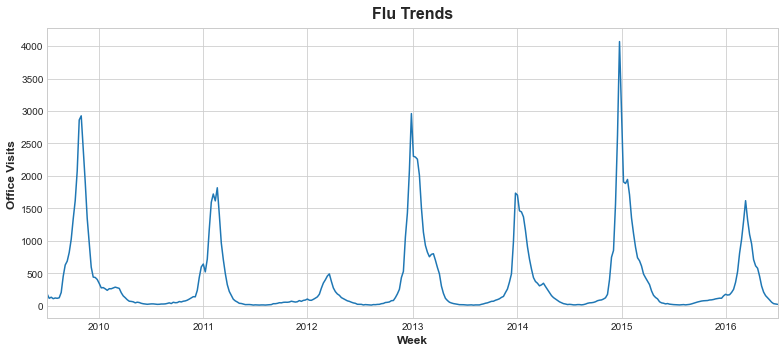

In [35]:
ax = flu_trends['FluVisits'].plot(title='Flu Trends')
ax.set(ylabel="Office Visits")

## 2. 지연 속성 확인하기

Our *Flu Trends* data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

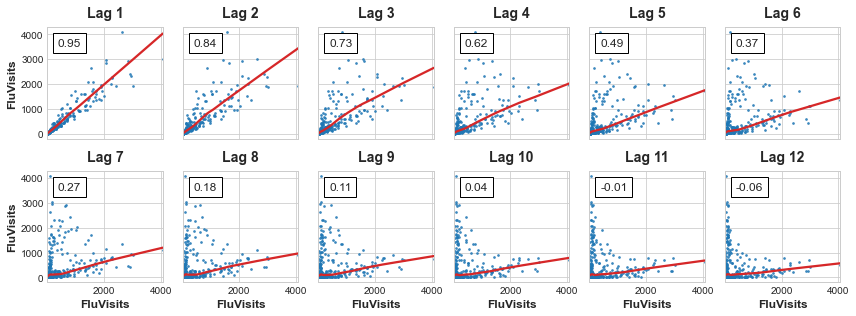

In [12]:
_= util.plot_lags(flu_trends.FluVisits, lags=12, nrows=2)

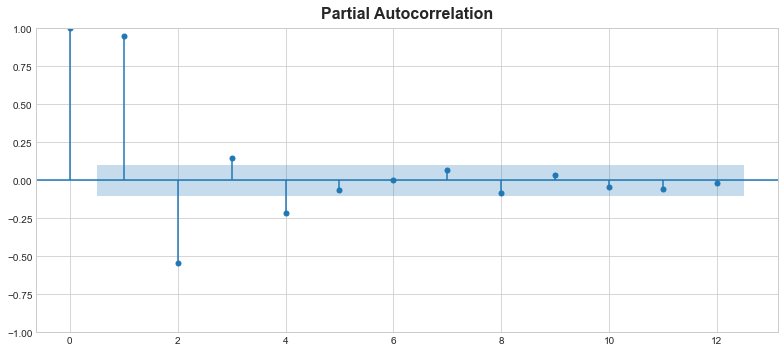

In [14]:
_ = plot_pacf(flu_trends.FluVisits, lags=12)

## 3. 데이터 전처리


The lag plots indicate that the relationship of `FluVisits` to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. We can lag a time series in Pandas with the `shift` method. For this problem, we'll fill in the missing values the lagging creates with `0.0`.

In [15]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In previous lessons, we were able to create forecasts for as many steps as we liked beyond the training data. When using lag features, however, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.

We'll see strategies for handling this problem in Lesson 6. For this example, we'll just use a values from a test set.

In [ ]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

## 4. 학습

In [ ]:
# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)

## 5. 예측

In [17]:
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

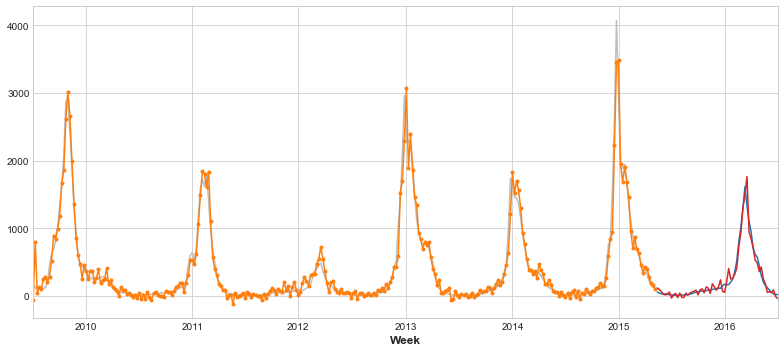

In [53]:
ax = y_train.plot(color="0.75", legend=False)
ax = y_test.plot()
ax = y_pred.plot(ax=ax, style=".-")
_ = y_fore.plot(ax=ax, color='C3')

---

Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.

<AxesSubplot:xlabel='Week'>

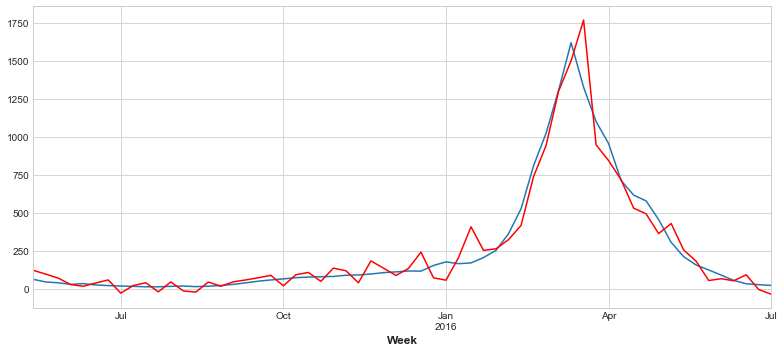

In [47]:
y_test.plot()
y_fore.plot(color='r')

To improve the forecast we could try to find *leading indicators*, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase `'FluCough'` against the target `'FluVisits'` suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

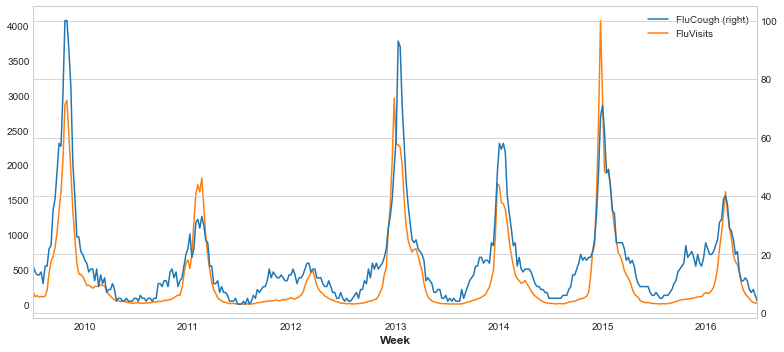

In [21]:

ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

The dataset contains 129 such terms, but we'll just use a few.

In [22]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.

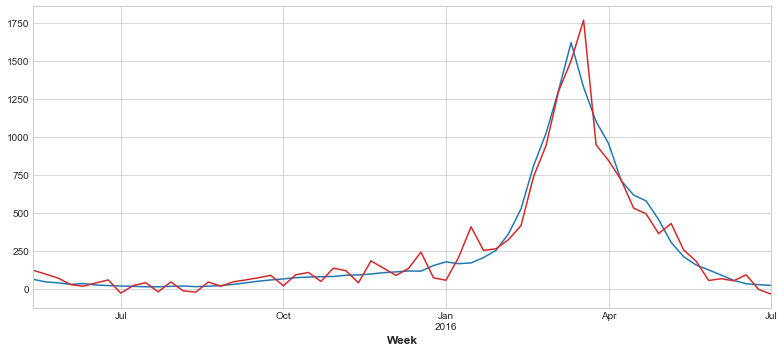

In [24]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot()
_ = y_fore.plot(ax=ax, color='C3')

---

The time series illustrated in this lesson are what you might call "purely cyclic": they have no obvious trend or seasonality. It's not uncommon though for time series to possess trend, seasonality, and cycles -- all three components at once. You could model such series with linear regression by just adding the appropriate features for each component. You can even combine models trained to learn the components separately, which we'll learn how to do in the next lesson with *forecasting hybrids*.